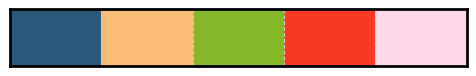

In [3]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

In [19]:
def sample_violin_plot():
    df = sns.load_dataset("titanic")
    custom_palette = {'no': '#0072B2', 'asd': '#56B4E9', 'yes': '#009E73'}
    ax = sns.violinplot(data=df, x="class", y="age", hue="alive", split=True, inner='quart', width=0.8, linewidth=0.8, palette=custom_palette)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, labels=['a', 'b'])
    for l in ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in ax.lines[1::3]:
        l.set_linestyle('--')
        l.set_linewidth(1.4)
        l.set_color('#F7F056')
        l.set_alpha(0.8)
    ax.set(xlabel='common xlabel', ylabel='common ylabel')

In [20]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    custom_palette = {'Zest-all': '#88CCEE', 'Zest-saved': '#6699CC', 'EI-all': '#44AA99'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm', 
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette, 
                            width=width, linewidth=1.0, order=x_order)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)
        
    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance from Parent Input (%)')
    #tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [21]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [22]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index 
    #median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [23]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices) 
    return stats_df

# RQ1: How destructive are Zest's mutations in general? Are disruptive mutations beneficial for fuzzing?

In [24]:
experiment_name = 'ei-m510-mutation'
#process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"])
# load the df from pickle
mutation_df = pd.read_pickle('./mutation.pkl')

In [25]:
new_label_names = {'zest-testWithGenerator': 'Zest-all', 'zest-testWithGenerator-saved_only': 'Zest-saved', 'ei-no-havoc-testWithGenerator': 'EI-all', 'ei-no-havoc-testWithGenerator-saved_only': 'EI-saved'}
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
print(mutation_df['algorithm'].unique())

['Zest-all' 'Zest-saved' 'EI-all' 'EI-saved']


In [26]:
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
#ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]

In [27]:
all_input_df = all_input_df.drop(all_input_df[all_input_df.benchmark_name == 'chocopy'].index)
print(all_input_df.benchmark_name.unique())

['ant' 'maven' 'rhino' 'closure' 'gson' 'jackson' 'jython']


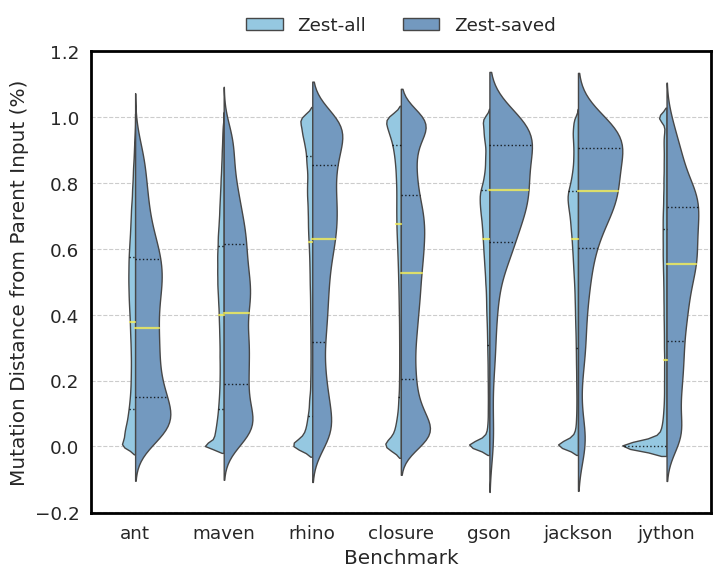

In [28]:
# zest all inputs vs. zest saved inputs
violin_plot_for_mutation_distance(zest_df, experiment_name, 'rq1_zest_all_vs_saved', width=1.0)

[0, 1, 2, 3, 4, 5, 7]
['ant', 'maven', 'rhino', 'closure', 'gson', 'jackson', 'jython']


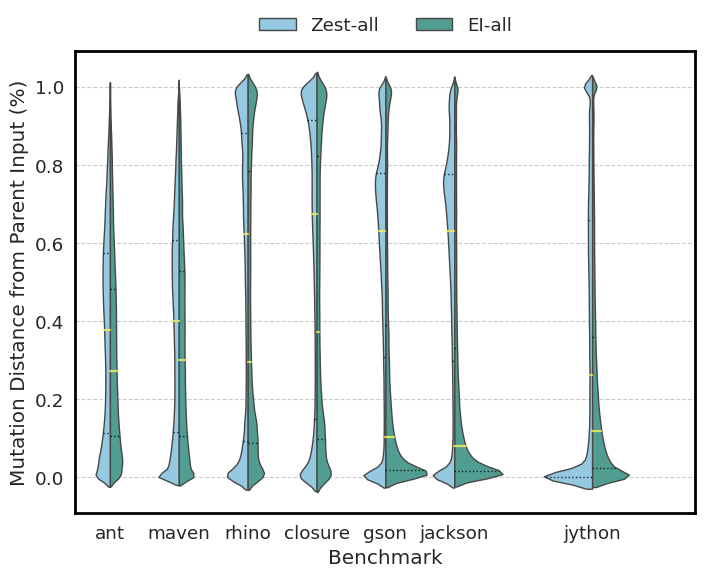

In [29]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'gson', 'jackson', 'NA1', 'jython', 'NA2')
violin_plot_for_mutation_distance(all_input_df, experiment_name, 'rq2_zest_vs_ei', width=1.4, x_order=x_order)

In [30]:
# stats table 
groupby = all_input_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
all_input_stats = beautify_stats_table(groupby)
all_input_stats
#bar_plot_for_median_mutation_distance(all_input_stats, experiment_name, 'all_input_bar_plot')
#box_plot_for_mutation_distance(zest_df, experiment_name, 'zest_box_plot')

algorithm benchmark_name    mutation                                     \
                                  count    median      mean       std  min   
0     EI-all            ant   3452883.0  0.271676  0.312729  0.236169  0.0   
1     EI-all        closure   2671438.0  0.373016  0.444973  0.360502  0.0   
2     EI-all           gson   9126156.0  0.103126  0.254315  0.310512  0.0   
3     EI-all        jackson   8347061.0  0.079193  0.221203  0.283981  0.0   
4     EI-all         jython   5337491.0  0.117647  0.235131  0.276421  0.0   
5     EI-all          maven   9416966.0  0.300813  0.337184  0.257235  0.0   
6     EI-all          rhino   5343517.0  0.294118  0.414837  0.357147  0.0   
7   Zest-all            ant   4414429.0  0.376712  0.367846  0.259308  0.0   
8   Zest-all        closure   4227343.0  0.674625  0.567700  0.369213  0.0   
9   Zest-all           gson   8066208.0  0.629310  0.542710  0.315610  0.0   
10  Zest-all        jackson   7867518.0  0.631111  0.538080  0.312901  0.0   
11  Zest-all         jython   7895065.0  0.262500  0.351471  0.350440  0.0   
12  Zest-all          maven  16429712.0  0.400000  0.387120  0.275879  0.0   
13  Zest-all          rhino   7466363.0  0.622146  0.525839  0.372346  0.0   

              
         max  
0   0.986270  
1   1.000000  
2   0.999680  
3   0.999662  
4   1.000000  
5   0.996723  
6   1.000000  
7   0.987151  
8   1.000000  
9   0.999676  
10  0.999668  
11  1.000000  
12  0.996414  
13  1.000000